## Import Libralies

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

import os
import re

import numpy as np
import pandas as pd
from joblib import Parallel, delayed

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
def load_dataset(data_dir_path='../data/raw/'):
    print('Reading train.csv file....')
    train = pd.read_csv(data_dir_path + 'train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv(data_dir_path + 'test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv(data_dir_path + 'train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv(data_dir_path + 'specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv(data_dir_path + 'sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(
        sample_submission.shape[0], sample_submission.shape[1]))

    return train, test, train_labels, specs, sample_submission

In [3]:
if os.path.exists('/kaggle/input/data-science-bowl-2019/'):
    raw_train, raw_test, train_labels, specs, sample_submission = load_dataset('/kaggle/input/data-science-bowl-2019/')
else:
    raw_train, raw_test, train_labels, specs, sample_submission = load_dataset()


del train_labels, specs

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


In [4]:
print(raw_train.shape)
raw_train.head()

(11341042, 11)


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [5]:
test = raw_test.copy()

## Transform Data

In [6]:
# Assesmentが含まれないinstallation_idは学習に使えないので除外
keep_ids = raw_train.loc[raw_train['type'] == 'Assessment', 'installation_id'].unique()
train = raw_train[raw_train.installation_id.isin(keep_ids)].reset_index(drop=True)

train['event_code'] = train['event_code'].astype(str)
test['event_code'] = test['event_code'].astype(str)

# title をLGBMやpandasが扱いやすい形に変換
train['title'] = train['title'].apply(lambda x: "".join(c if c.isalnum() else "_" for c in str(x)))
test['title'] = test['title'].apply(lambda x: "".join(c if c.isalnum() else "_" for c in str(x)))

# 各種イベントデータのリストを取得
all_event_code = np.union1d(train['event_code'].unique(), test['event_code'].unique())
all_title = np.union1d(train['title'].unique(), test['title'].unique())
all_world = np.union1d(train['world'].unique(), test['world'].unique())
all_session_type = np.union1d(train['type'].unique(), test['type'].unique())

In [7]:
print(train.shape)
train.head()

(8294138, 11)


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,34ba1a28d02ba8ba,2019-08-06T04:57:18.904Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome_to_Lost_Lagoon_,Clip,NONE
1,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma_Peak___Level_1,Clip,MAGMAPEAK
2,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle_Builder__Activity_,Activity,MAGMAPEAK
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle_Builder__Activity_,Activity,MAGMAPEAK
4,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle_Builder__Activity_,Activity,MAGMAPEAK


In [8]:
def parse_assessment_session(session, title):
    attempt_code = '4100' if title!='Bird Measurer (Assessment)' else '4110'
    attempt_event = session[session['event_code']==attempt_code]
    
    num_correct = attempt_event['event_data'].str.contains('"correct":true').astype(int).sum()
    num_incorrect = attempt_event['event_data'].str.contains('"correct":false').astype(int).sum()
    
    accuracy = num_correct / (num_correct+num_incorrect)
    
    def calc_accuracy_group(accuracy):
        if accuracy == 1.0:
            return 3
        elif accuracy == 1.0 / 2:
            return 2
        elif accuracy <= 1.0 / 3 and accuracy > 0.0:
            return 1
        else:
            return 0
    
    accuracy_group = calc_accuracy_group(accuracy)
    return num_correct, num_incorrect, accuracy, accuracy_group


def parse_session_data(data, is_test_data=False):
    # divise_data is data for each installation_id.
    train_data = []
    # 特定のinstallation_idごとのsessionデータを取得
    for i_id, sessions in tqdm(data.groupby('installation_id', sort=False)):
        # installation_idごとの特徴量を初期化
        total_session_data = {}
        
        # installation_idを取得
        total_session_data['installation_id'] = i_id
        # event_code, type, world, titleごとの各種カウント
        session_type_count = {'Clip': 0, 'Activity': 0, 'Assessment': 0, 'Game': 0}
        session_title_count = {title: 0 for title in all_title}
        session_world_count = {'NONE': 0, 'MAGMAPEAK': 0, 'CRYSTALCAVES': 0, 'TREETOPCITY': 0}
        event_code_count =  {code: 0 for code in all_event_code}
        # type, titleごとのセッション時間
        time_spent_each_type = {'time_spent_Clip': 0, 'time_spent_Activity': 0, 'time_spent_Assessment': 0, 'time_spent_Game': 0} # session_type != 'Assessment'としていた。。？
        time_spent_each_title = {f'time_spent_{title}': 0 for title in all_title} # session_type != 'Assessment'としていた。。？
        # カウントデータから算出
        total_event_count = 0 # 合計イベント回数
        total_type_count = 0 # 合計タイプ個数
        total_time_spent = 0 # 合計セッション時間
        # 最後のセッションタイプ
        last_session_type = None 
        last_session_time_msec = None
        # Assesment から得られるデータ
        num_assessment_count = 0
        accuracy_group_count = {f'accuracy_group_{i}':0 for i in range(4)} # 過去の評価値
        accumulated_num_incorrect = 0
        accumulated_num_correct = 0
        accumulated_accuracy = 0
        accumulated_accuracy_group = 0

        for session_id, session in sessions.groupby('game_session', sort=False):
            # セッション情報からデータを取得
            game_session = session_id
            session_type = session['type'].unique()[0]
            session_title = session['title'].unique()[0]
            session_world = session['world'].unique()[0]
            
            event_count_dict = session['event_code'].value_counts().to_dict()
            session_game_time = session['game_time'].iloc[-1]
            # 累積セッションデータを更新
            session_type_count[session_type] += 1
            session_title_count[session_title] += 1
            session_world_count[session_world] += 1
            time_spent_each_type[f'time_spent_{session_type}'] += session_game_time
            time_spent_each_title[f'time_spent_{session_title}'] += session_game_time
            for k, v in event_count_dict.items():
                event_code_count[str(k)] += v
                
            avg_event_count = np.mean(np.ravel(list(event_code_count.values())))
            avg_type_count = np.mean(np.ravel(list(time_spent_each_type.values())))
            avg_time_spent = np.mean(np.ravel(list(time_spent_each_title.values())))

            total_event_count = sum(event_code_count.values())
            total_type_count = sum(time_spent_each_type.values())
            total_time_spent = sum(time_spent_each_title.values())
            

            if session_type == 'Assessment':
                # Assessmentセッションのデータを解析
                num_correct, num_incorrect, accuracy, accuracy_group = parse_assessment_session(session, session_title)
                # 条件を満たす場合、学習データとして追加
                if num_correct+num_incorrect > 0 or is_test_data:
                    train_data.append(dict(total_session_data, **{'accuracy_group': accuracy_group}))

                # 特徴量を計算
                num_assessment_count += 1
                accuracy_group_count[f'accuracy_group_{accuracy_group}'] += 1
                accumulated_num_incorrect += num_incorrect
                accumulated_num_correct += num_correct
                accumulated_accuracy += accuracy
                accumulated_accuracy_group += accuracy_group
                
                total_session_data.update(accuracy_group_count)
                total_session_data.update({
                    'accumulated_num_incorrect': accumulated_num_incorrect,
                    'accumulated_num_correct': accumulated_num_correct,
                    'accumulated_accuracy': accumulated_accuracy / num_assessment_count if num_assessment_count>0 else 0,
                    'accumulated_accuracy_group': accumulated_accuracy_group / num_assessment_count if num_assessment_count>0 else 0,
                })

            # セッションデータの解析
            total_session_data.update(session_type_count)
            total_session_data.update(session_title_count)
            total_session_data.update(session_world_count)
            total_session_data.update(event_code_count)
            total_session_data.update(time_spent_each_type)
            total_session_data.update(time_spent_each_title)
            total_session_data.update({ 
                'game_session': game_session,
                'session_title': session_title,
                'session_world': session_world,
                'avg_event_count': avg_event_count,
                'avg_type_count': avg_type_count,
                'avg_time_spent': avg_time_spent,
                'total_event_count': total_event_count,
                'total_type_count': total_type_count,
                'total_time_spent': total_time_spent,
                'last_session_type': last_session_type,
                'last_session_time_msec': last_session_time_msec
            })
            
            # Assessmentでなければ、最後のセッション情報を更新する。
            last_session_type = session_type
            last_session_time_msec = session_game_time

    df = pd.DataFrame(train_data)
    
    # dataframe への特徴量エンジニアリング
    df['MEAN_avg_time_spent_by_installation_id'] = df.groupby(['installation_id'])['avg_time_spent'].transform('mean')
    df['MEAN_total_event_count_by_installation_id'] = df.groupby(['installation_id'])['total_event_count'].transform('mean')
    df['total_avg_accuracy'] = df['accumulated_num_correct'] / (df['accumulated_num_correct']+df['accumulated_num_incorrect'])
    
    temp = data.groupby('installation_id')['title'].agg({'NUNIQUE_session_title_by_installation_id': 'nunique'})
    df = df.merge(temp, on='installation_id', how='left')
    
    # テストデータの場合、最後の１Assesmentセッションのみを予測データとして扱う。
    if is_test_data:
        df = df.drop_duplicates(['installation_id'], keep='last')
    return df

In [9]:
%%time
df = parse_session_data(train, is_test_data=False)


CPU times: user 5min 39s, sys: 4.91 s, total: 5min 44s
Wall time: 5min 47s


In [10]:
print(df.shape)
df.head()

(16681, 167)


,installation_id,Clip,Activity,Assessment,Game,12_Monkeys,Air_Show,All_Star_Sorting,Balancing_Act,Bird_Measurer__Assessment_,...,accuracy_group_2,accuracy_group_3,accumulated_num_incorrect,accumulated_num_correct,accumulated_accuracy,accumulated_accuracy_group,MEAN_avg_time_spent_by_installation_id,MEAN_total_event_count_by_installation_id,total_avg_accuracy,NUNIQUE_session_title_by_installation_id
0,0006a69f,11.0,3.0,0.0,4.0,1.0,0.0,3.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,52066.789773,1655.500000,NaN,28
1,0006a69f,14.0,4.0,2.0,6.0,1.0,1.0,3.0,0.0,1.0,...,0.0,1.0,0.0,1.0,NaN,1.5,52066.789773,1655.500000,1.00,28
2,0006a69f,24.0,9.0,4.0,10.0,2.0,1.0,4.0,0.0,1.0,...,0.0,2.0,0.0,2.0,NaN,1.5,52066.789773,1655.500000,1.00,28
3,0006a69f,28.0,10.0,5.0,13.0,2.0,2.0,4.0,0.0,1.0,...,1.0,2.0,1.0,3.0,NaN,1.6,52066.789773,1655.500000,0.75,28
4,0006c192,15.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,37267.628788,1820.666667,NaN,31


In [13]:
%%time
test_df = parse_session_data(test, is_test_data=True)


CPU times: user 50.6 s, sys: 730 ms, total: 51.3 s
Wall time: 52.9 s


In [14]:
print(test_df.shape)
test_df.head()

(1000, 167)


,installation_id,Clip,Activity,Assessment,Game,12_Monkeys,Air_Show,All_Star_Sorting,Balancing_Act,Bird_Measurer__Assessment_,...,accuracy_group_2,accuracy_group_3,accumulated_num_incorrect,accumulated_num_correct,accumulated_accuracy,accumulated_accuracy_group,MEAN_avg_time_spent_by_installation_id,MEAN_total_event_count_by_installation_id,total_avg_accuracy,NUNIQUE_session_title_by_installation_id
1,00abaee7,14.0,7.0,1.0,3.0,2.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,3.0,55182.500000,574.500000,1.0,20
7,01242218,29.0,11.0,5.0,12.0,1.0,1.0,1.0,3.0,1.0,...,3.0,1.0,6.0,4.0,0.5,1.8,52888.318182,1768.666667,0.4,43
8,017c5718,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2564.772727,149.000000,NaN,6
9,01a44906,10.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4278.818182,233.000000,NaN,11
10,01bc6cb6,17.0,1.0,0.0,6.0,0.0,0.0,3.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,27422.227273,951.000000,NaN,17


## Training Model And Prediction

In [15]:
from collections import Counter

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance

In [16]:
def eval_qwk_lgb_regr(train, y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(train['accuracy_group'])
    for k in dist:
        dist[k] /= len(train)
    train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [17]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.oof_pred, self.y_pred, self.score, self.models = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        models = []
        
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            # train
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            models.append(model)
            # predict validation data
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(self.train_df, y_val, oof_pred[val_idx])[1]))
        
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df, self.train_df[self.target], oof_pred)
        if self.verbose:
            print(f'\nOur oof cohen kappa score is: {loss_score}\n')
        
        return oof_pred, y_pred, loss_score, models

In [18]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {
            'n_estimators':5000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.01,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'early_stopping_rounds': 100,
            'random_state': 42
        }
        return params
    
    def get_feature_importance(self, models):
        feature_importance = pd.DataFrame(
            [model.feature_importance() for model in models],
            columns=models[0].feature_name()
        ).T

        feature_importance['Agerage_Importance'] = feature_importance.iloc[:, :len(models)].mean(axis=1)
        feature_importance['importance_std'] = feature_importance.iloc[:, :len(models)].std(axis=1)

        feature_importance.sort_values(by='Agerage_Importance', inplace=True)
        return feature_importance
    
    def plot_importance(self, models, max_num_features=50, figsize=(12, 15)):
        feature_importance = self.get_feature_importance(models)
        plt.figure(figsize=figsize)
        
        feature_importance[-max_num_features:].plot(
            kind='barh', title='Feature importance', figsize=figsize,
            y='Agerage_Importance', xerr='importance_std',
            grid=True, align="center"
        )
        plt.legend()
        plt.show()

In [19]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(
            self.params, train_set, 
            num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
            verbose_eval=verbosity, early_stopping_rounds=100
        )
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000}

        return params

In [20]:
categoricals = ['session_title', 'session_world', 'last_session_type']

world_dict = {l: i for i, l in enumerate(all_world)}
title_dict = {l: i for i, l in enumerate(all_title)}
type_dict = {l: i for i, l in enumerate(all_session_type)}
    
for c in categoricals:
    df[c] = df[c].map(title_dict).fillna(-1).astype(int)
    test_df[c] = test_df[c].map(title_dict).fillna(-1).astype(int)

In [21]:
features = df.columns.tolist()
to_remove_cols = ['installation_id', 'game_session', 'accuracy_group']
features = list(set(features) - set(to_remove_cols))

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.06298	valid_1's rmse: 1.08751
[200]	training's rmse: 1.00604	valid_1's rmse: 1.05543
[300]	training's rmse: 0.974248	valid_1's rmse: 1.04699
[400]	training's rmse: 0.949984	valid_1's rmse: 1.0427
[500]	training's rmse: 0.928784	valid_1's rmse: 1.0405
[600]	training's rmse: 0.909751	valid_1's rmse: 1.03926
[700]	training's rmse: 0.892511	valid_1's rmse: 1.03834
[800]	training's rmse: 0.875823	valid_1's rmse: 1.0378
[900]	training's rmse: 0.860083	valid_1's rmse: 1.03782
Early stopping, best iteration is:
[822]	training's rmse: 0.872372	valid_1's rmse: 1.03764
Partial score of fold 0 is: 0.5106565321455196
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.06182	valid_1's rmse: 1.09279
[200]	training's rmse: 1.00522	valid_1's rmse: 1.06213
[300]	training's rmse: 0.972634	valid_1's rmse: 1.05313
[400]	training's rmse: 0.947317	valid_1's rmse: 1.05027
[500]	training's 

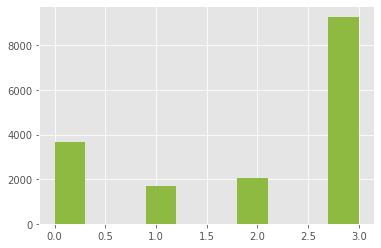

In [22]:
lgb_model = Lgb_Model(df, test_df, features, categoricals=categoricals)
# xgb_model = Xgb_Model(df, test_df, features, categoricals=categoricals)

In [23]:
# score of v1000 is 0.5385181015771213
# add feature of accuracy_group_{/d}: 0.5403076234416431
# add feature of assessment`s accumulated data: 0.5443877332927528

<Figure size 864x1080 with 0 Axes>

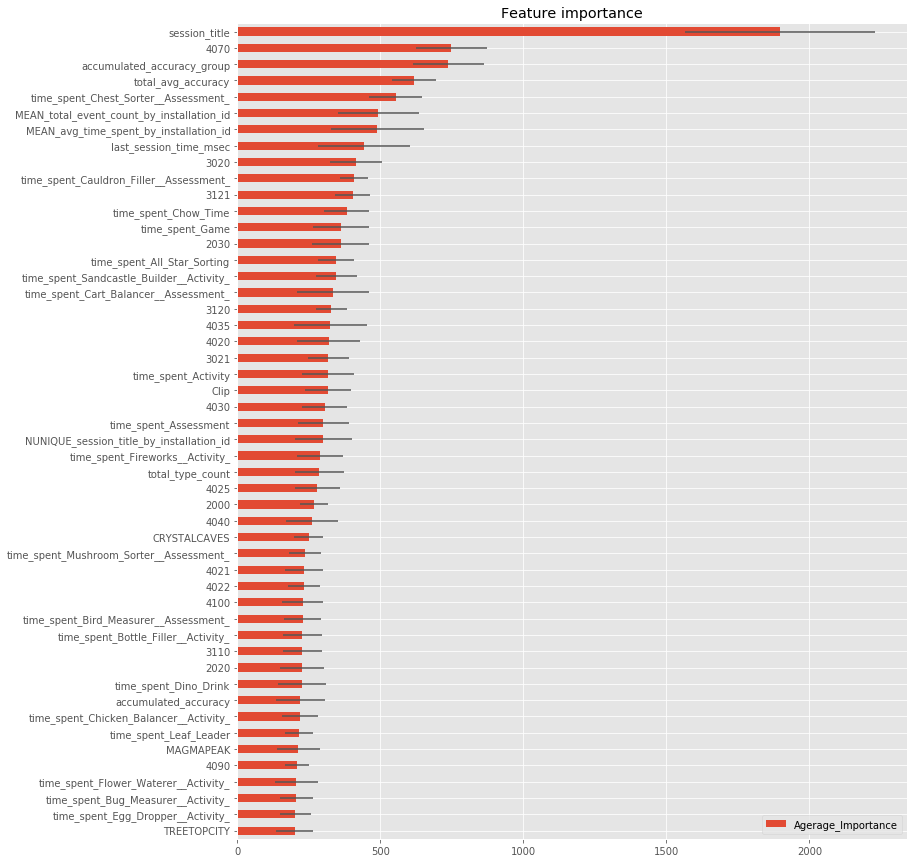

In [24]:
lgb_model.plot_importance(lgb_model.models)

## Submission

In [25]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -cohen_kappa_score(y, X_p, weights='quadratic')

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    
    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [26]:
weights = {'lbg': 0.70, 'cat': 0, 'xgb': 0.30, 'nn': 0.00}
# final_pred = (lgb_model.y_pred * weights['lbg']) + (xgb_model.y_pred * weights['xgb'])
final_pred_reg = lgb_model.y_pred

print(final_pred_reg.shape)

(1000,)


In [27]:
trian_pred = lgb_model.oof_pred

optR = OptimizedRounder()
optR.fit(trian_pred, df['accuracy_group'])
coefficients = optR.coefficients()

opt_preds = optR.predict(trian_pred.reshape(-1, ), coefficients)

final_pred = final_pred_reg
final_pred[final_pred_reg <= coefficients[0]] = 0
final_pred[np.where(np.logical_and(final_pred_reg > coefficients[0], final_pred_reg <= coefficients[1]))] = 1
final_pred[np.where(np.logical_and(final_pred_reg > coefficients[1], final_pred_reg <= coefficients[2]))] = 2
final_pred[final_pred_reg > coefficients[2]] = 3

In [28]:
# 閾値最適化されていない分類方法

# dist = Counter(df['accuracy_group'])

# for k in dist:
#     dist[k] /= len(df)
# df['accuracy_group'].hist()

# acum = 0
# bound = {}
# for i in range(3):
#     acum += dist[i]
#     bound[i] = np.percentile(final_pred, acum * 100)
    
# print(bound)

# def classify(x):
#     if x <= bound[0]:
#         return 0
#     elif x <= bound[1]:
#         return 1
#     elif x <= bound[2]:
#         return 2
#     else:
#         return 3
    
# final_pred = np.array(list(map(classify, final_pred)))

In [29]:
sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True).sort_index()

0    0.115
1    0.140
2    0.356
3    0.389
Name: accuracy_group, dtype: float64